In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import xgboost as xgb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [2]:
# Reading Dataset
train_set = pd.read_csv(r'/kaggle/input/titanic/train.csv')
test_set = pd.read_csv(r'/kaggle/input/titanic/test.csv')
gender_submission = pd.read_csv(r'/kaggle/input/titanic/gender_submission.csv')


# Exploratory Data Analysis

In [3]:
# Checking columns null values count
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# Summary Statistics of the int columns of the dataframe
train_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


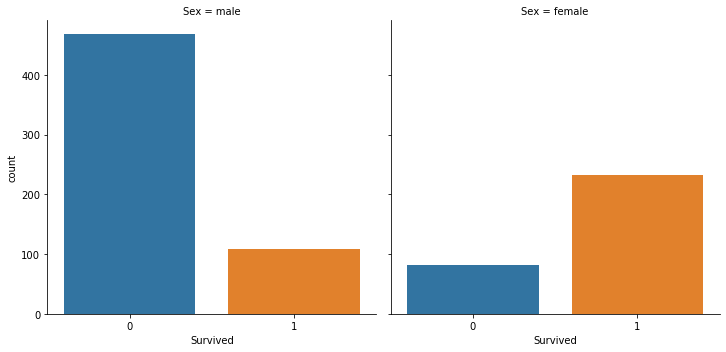

In [5]:
# Checking survival ratio based on Sex
sns.factorplot(x='Survived', col='Sex', kind='count', data=train_set);

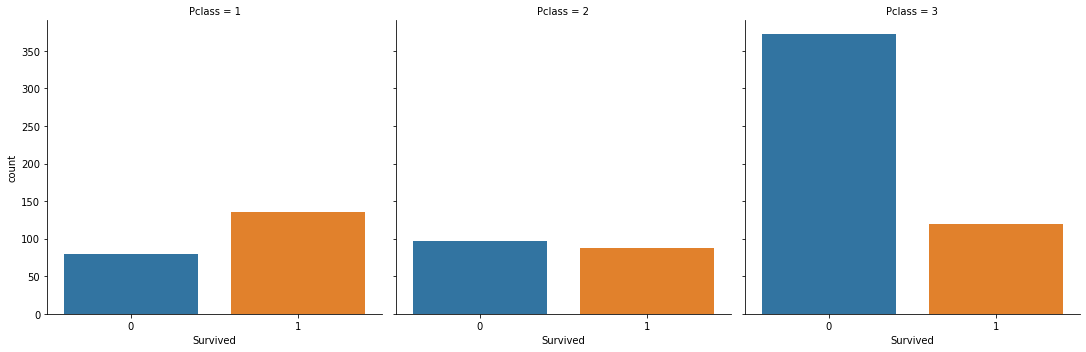

In [6]:
# Checking survival ratio based on Pclass
sns.factorplot(x='Survived', col='Pclass', kind='count', data=train_set)

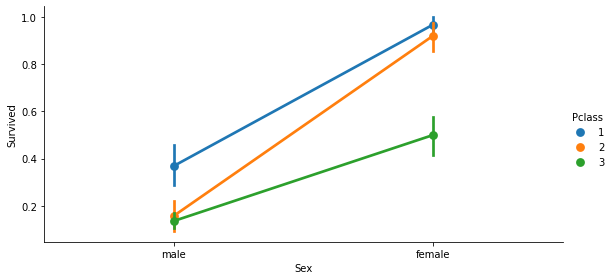

In [7]:
# Checking the survival based on Sex and PClass
sns.factorplot('Sex', 'Survived', hue='Pclass', size=4, aspect=2, data=train_set)

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Fare, dtype: object

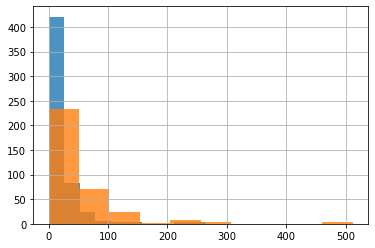

In [8]:
# Checking Survival based on Fare amount
train_set.groupby('Survived').Fare.hist(alpha=0.8)

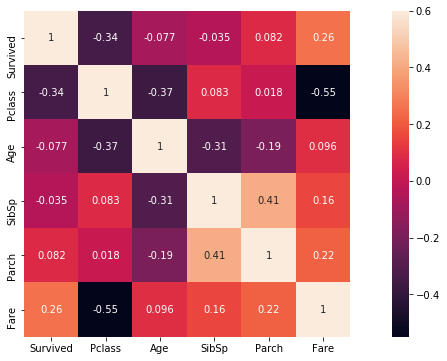

In [9]:
# Heatmap
plt.figure(figsize=(15,6))
sns.heatmap(train_set.drop('PassengerId',axis=1).corr(), vmax=0.6, square=True, annot=True)


# Feature Extraction

In [10]:
# Creating copy of train data
titanic_train_data = train_set.copy()
titanic_test_data =test_set.copy()

In [11]:
# Checking Unique Values of columns
pid_unique = titanic_train_data.PassengerId.nunique()
name_unique = titanic_train_data.Name.nunique()
ticket_unique = titanic_train_data.Ticket.nunique()

print('Passenger ID : ',pid_unique)
print('Name : ',name_unique)
print('Ticket : ',ticket_unique)

Passenger ID :  891
Name :  891
Ticket :  681


In [12]:
# Dropping Passenger ID,  Name, Ticket, Fare because too many unique values
titanic_train_data = titanic_train_data[titanic_train_data.columns.drop(['PassengerId', 'Name', 'Ticket', 'Fare'])]

In [13]:
# Train missing values (in percent)
train_missing = (titanic_train_data.isnull().sum() / len(titanic_train_data)).sort_values(ascending = False)
train_missing.head(12)

Cabin       0.771044
Age         0.198653
Embarked    0.002245
Parch       0.000000
SibSp       0.000000
Sex         0.000000
Pclass      0.000000
Survived    0.000000
dtype: float64

In [14]:
# Dropping columns with Null Values more than 75%
train_missing = train_missing.index[train_missing > 0.75]
titanic_train_data.drop(train_missing,axis=1,inplace=True)
titanic_train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


In [15]:
# Filling up the NaN values in Embarked with the most appeared value
embarked_mode = titanic_train_data['Embarked'].mode()
titanic_train_data['Embarked'] = titanic_train_data['Embarked'].fillna(embarked_mode[0])

In [16]:
# Filling up the NaN values in Age with the mean Age
mean = titanic_train_data["Age"].mean()
age_slice = titanic_train_data["Age"].copy()
age_slice[np.isnan(age_slice)] = mean
titanic_train_data["Age"] = age_slice
titanic_train_data["Age"] = titanic_train_data["Age"].astype(int)

mean1 = titanic_test_data["Age"].mean()
age_slice1 = titanic_test_data["Age"].copy()
age_slice1[np.isnan(age_slice1)] = mean1
titanic_test_data["Age"] = age_slice1
titanic_test_data["Age"] = titanic_test_data["Age"].astype(int)


In [17]:
# Convert the categorical value of Sex and Embarked into numeric
titanic_train_data['Sex'] = titanic_train_data['Sex'].map( {'female': 1, 'male': 0} )
titanic_train_data['Embarked'] = titanic_train_data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} )

titanic_test_data['Sex'] = titanic_test_data['Sex'].map( {'female': 1, 'male': 0} )
titanic_test_data['Embarked'] = titanic_test_data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} )

titanic_train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,0,22,1,0,0
1,1,1,1,38,1,0,1
2,1,3,1,26,0,0,0
3,1,1,1,35,1,0,0
4,0,3,0,35,0,0,0


In [18]:
# Converting age in brackets of 15
titanic_train_data.loc[ titanic_train_data['Age'] <= 15, 'Age'] = 0
titanic_train_data.loc[(titanic_train_data['Age'] > 15) & (titanic_train_data['Age'] <= 30), 'Age'] = 1
titanic_train_data.loc[(titanic_train_data['Age'] > 30) & (titanic_train_data['Age'] <= 45), 'Age'] = 2
titanic_train_data.loc[(titanic_train_data['Age'] > 45) & (titanic_train_data['Age'] <= 60), 'Age'] = 3
titanic_train_data.loc[ titanic_train_data['Age'] > 60, 'Age'] = 4

In [19]:
titanic_train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,0,1,1,0,0
1,1,1,1,2,1,0,1
2,1,3,1,1,0,0,0
3,1,1,1,2,1,0,0
4,0,3,0,2,0,0,0


In [20]:
# Creating Test Train Split
X_train = titanic_train_data.drop("Survived", axis=1)
X_test = titanic_test_data.drop(["PassengerId", "Name", "Ticket", "Fare", "Cabin"], axis=1).copy()
y_train = titanic_train_data["Survived"]
y_test = gender_submission["Survived"]

In [21]:
# XGBooat Classifier Hyperparameter
finclf=xgb.XGBClassifier(early_stopping_rounds=5,n_jobs=4, learning_rate=0.05, max_depth=6, n_estimators=1000, subsample=0.8)

In [22]:
# Training Model
finclf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=5,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.05,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=4,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

In [23]:
# Predicting the test dataset
pred= finclf.predict(X_test)

In [24]:
# Checking the Accuracy
np.mean(pred == y_test)

0.8851674641148325

In [ ]:
# Submission
submission = pd.DataFrame({
        "PassengerId": test_set["PassengerId"],
        "Survived": pred
    })
submission.to_csv(r'/kaggle/input/titanic/submission.csv', index=False)